# Experiment 6: Decision Tree and Random Forest
## A Comparative Classification Study on Wisconsin Diagnostic Breast Cancer Dataset

**Objective:**
- Implement a Decision Tree classifier.
- Extend the Decision Tree into a Random Forest ensemble model.
- Study the impact of hyperparameters on overfitting and generalization.
- Select optimal hyperparameters using 5-Fold Cross-Validation.
- Compare single-tree and ensemble-tree models.

**Author:** Monesh M

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Create directories for saving plots if they don't exist
os.makedirs('Images/PNG', exist_ok=True)
os.makedirs('Images/EPS', exist_ok=True)

def save_plot(name):
    plt.savefig(f'Images/PNG/{name}.png', bbox_inches='tight')
    plt.savefig(f'Images/EPS/{name}.eps', bbox_inches='tight')
    print(f"Saved: {name}")

## 1. Load the Dataset and Encode Class Labels

The dataset is the **Wisconsin Diagnostic Breast Cancer (WDBC)** dataset.
- Attributes include ID, diagnosis (M = malignant, B = benign), and 30 real-valued input features.

In [2]:
# Column names from wdbc.names
column_names = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
                'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 
                'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 
                'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 
                'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']

df = pd.read_csv('Dataset/wdbc.data', names=column_names)
df.drop('id', axis=1, inplace=True)

print(f"Dataset shape: {df.shape}")
display(df.head())

# Encode diagnosis: M -> 1, B -> 0
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
classes = le.classes_
print(f"Encoded classes: {classes} -> [0, 1]")

Dataset shape: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Encoded classes: ['B' 'M'] -> [0, 1]


## 2. Exploratory Data Analysis (EDA)

C:\Users\MONESH M\AppData\Local\Temp\ipykernel_36420\2680690177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette='viridis')


Saved: class_distribution


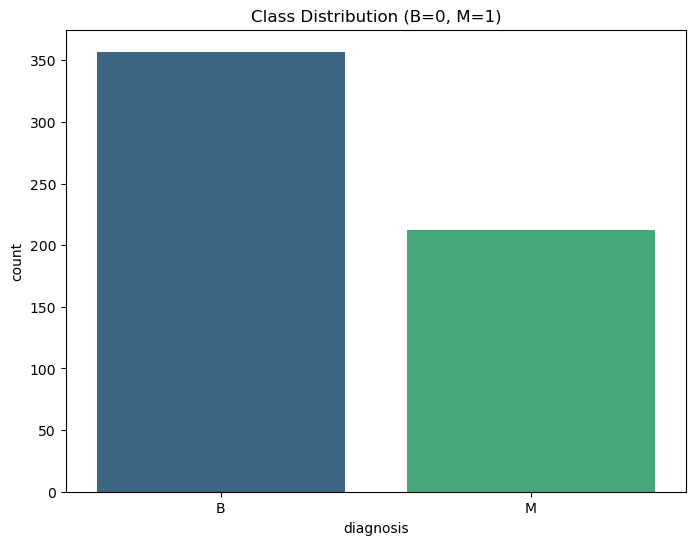

diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64


In [3]:
# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Class Distribution (B=0, M=1)')
plt.xticks(ticks=[0, 1], labels=classes)
save_plot('class_distribution')
plt.show()

print(df['diagnosis'].value_counts(normalize=True))

Saved: correlation_heatmap


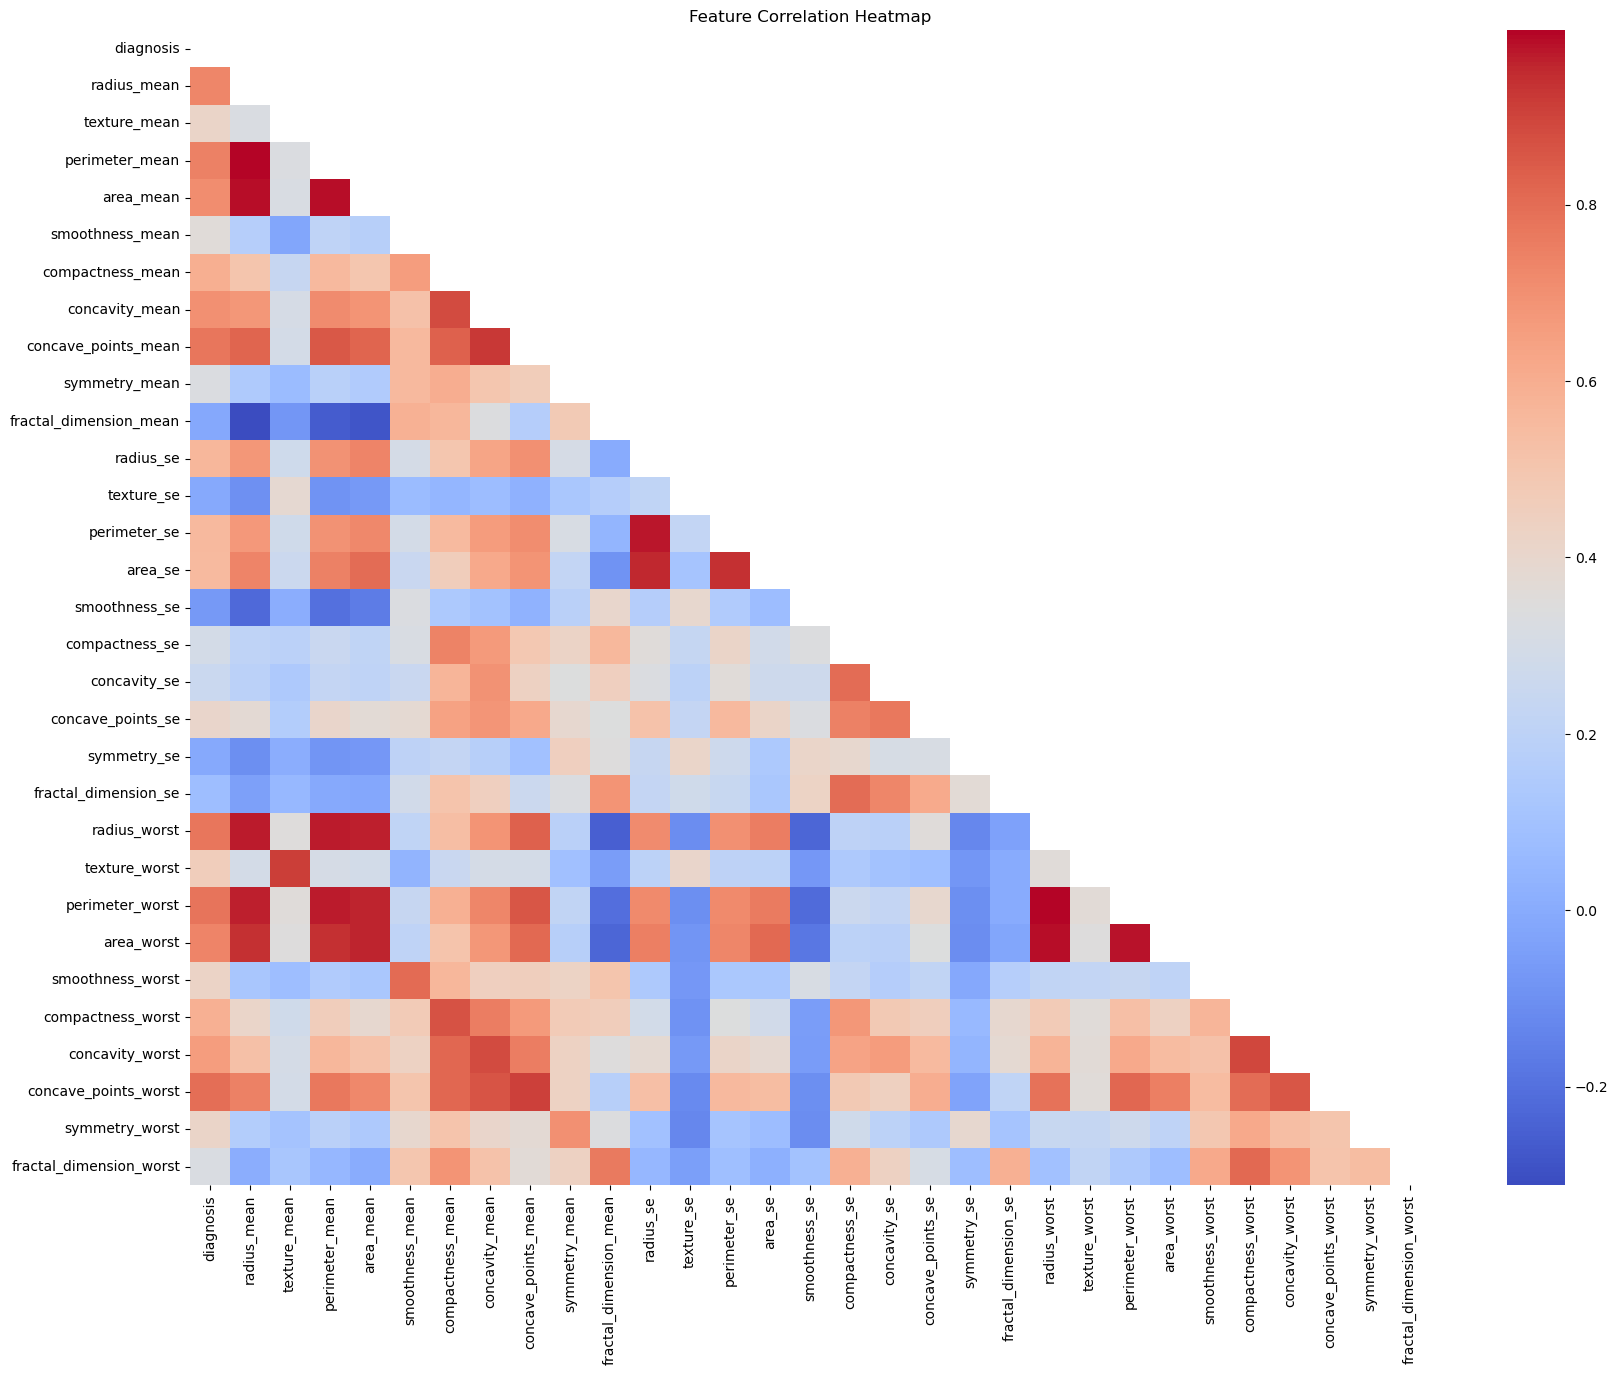

In [4]:
# Feature Correlation Analysis
plt.figure(figsize=(20, 15))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
save_plot('correlation_heatmap')
plt.show()

## 3. Train-Test Split
Split the dataset into training and testing sets (80-20).

In [5]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (455, 30)
Test size: (114, 30)


## 4. Decision Tree Classifier: Hyperparameter Tuning

We perform 5-Fold Cross-Validation across a search space to find the optimal single-tree configuration.

In [6]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
dt_grid.fit(X_train, y_train)

print(f"Best Decision Tree Params: {dt_grid.best_params_}")
print(f"Best CV Accuracy: {dt_grid.best_score_:.4f}")

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best CV Accuracy: 0.9473


### Table 1: Decision Tree Hyperparameter Evaluation

In [7]:
dt_results = pd.DataFrame(dt_grid.cv_results_)
dt_evaluation_table = dt_results[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
dt_evaluation_table.columns = ['Criterion', 'Max Depth', 'Avg CV Accuracy', 'Std Deviation']

# Displaying top 10 results for brevity
print("Table 1: Decision Tree Hyperparameter Evaluation (Top results)")
display(dt_evaluation_table.sort_values(by='Avg CV Accuracy', ascending=False).head(10))

Table 1: Decision Tree Hyperparameter Evaluation (Top results)


,Criterion,Max Depth,Avg CV Accuracy,Std Deviation
85,entropy,20,0.947253,0.021308
76,entropy,10,0.947253,0.021308
49,entropy,None,0.947253,0.021308
46,entropy,None,0.945055,0.020850
73,entropy,10,0.945055,0.020850
82,entropy,20,0.945055,0.020850
37,gini,20,0.938462,0.037168
1,gini,None,0.938462,0.037168
28,gini,10,0.938462,0.037168
67,entropy,5,0.938462,0.016447


## 5. Random Forest Classifier: Hyperparameter Tuning

We extend the Decision Tree into a Random Forest ensemble and repeat the 5-fold CV tuning.

In [8]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"Best Random Forest Params: {rf_grid.best_params_}")
print(f"Best CV Accuracy: {rf_grid.best_score_:.4f}")

Best Random Forest Params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Best CV Accuracy: 0.9714


### Table 2: Random Forest Hyperparameter Evaluation

In [9]:
rf_results_df = pd.DataFrame(rf_grid.cv_results_)
rf_evaluation_table = rf_results_df[['param_n_estimators', 'param_max_depth', 'param_max_features', 'mean_test_score']]
rf_evaluation_table.columns = ['n estimators', 'Max Depth', 'Max Features', 'Avg CV Accuracy']

print("Table 2: Random Forest Hyperparameter Evaluation (Top results)")
display(rf_evaluation_table.sort_values(by='Avg CV Accuracy', ascending=False).head(10))

Table 2: Random Forest Hyperparameter Evaluation (Top results)


,n estimators,Max Depth,Max Features,Avg CV Accuracy
35,200,10,log2,0.971429
34,100,10,log2,0.969231
22,100,None,log2,0.969231
12,50,10,sqrt,0.967033
23,200,None,log2,0.967033
0,50,None,sqrt,0.967033
21,50,None,log2,0.964835
33,50,10,log2,0.964835
31,100,10,sqrt,0.964835
19,100,None,sqrt,0.964835


## 6. Model Comparison and Analysis

### Table 3: 5-Fold Cross-Validation Accuracy Comparison
Comparison of the best models founded during tuning.

In [10]:
best_dt = dt_grid.best_estimator_
best_rf = rf_grid.best_estimator_

dt_cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5)
rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)

comparison_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Fold 1': [dt_cv_scores[0], rf_cv_scores[0]],
    'Fold 2': [dt_cv_scores[1], rf_cv_scores[1]],
    'Fold 3': [dt_cv_scores[2], rf_cv_scores[2]],
    'Fold 4': [dt_cv_scores[3], rf_cv_scores[3]],
    'Fold 5': [dt_cv_scores[4], rf_cv_scores[4]],
    'Average': [dt_cv_scores.mean(), rf_cv_scores.mean()]
})

print("Table 3: 5-Fold Cross-Validation Accuracy Comparison")
display(comparison_df)

Table 3: 5-Fold Cross-Validation Accuracy Comparison


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,Decision Tree,0.967033,0.967033,0.934066,0.956044,0.912088,0.947253
1,Random Forest,1.000000,0.989011,0.934066,0.989011,0.945055,0.971429


## 7. Performance Evaluation on Test Set

We evaluate both final models on the unseen test dataset using various metrics.

In [11]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"--- {name} Metrics ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}\n")
    
    return y_pred, y_prob, {'Acc': acc, 'Prec': prec, 'Rec': rec, 'F1': f1}

y_pred_dt, y_prob_dt, m_dt = evaluate_model(best_dt, X_test, y_test, "Decision Tree")
y_pred_rf, y_prob_rf, m_rf = evaluate_model(best_rf, X_test, y_test, "Random Forest")

--- Decision Tree Metrics ---
Accuracy:  0.9561
Precision: 1.0000
Recall:    0.8810
F1 Score:  0.9367

--- Random Forest Metrics ---
Accuracy:  0.9649
Precision: 1.0000
Recall:    0.9048
F1 Score:  0.9500



### Confusion Matrices

Saved: confusion_matrices


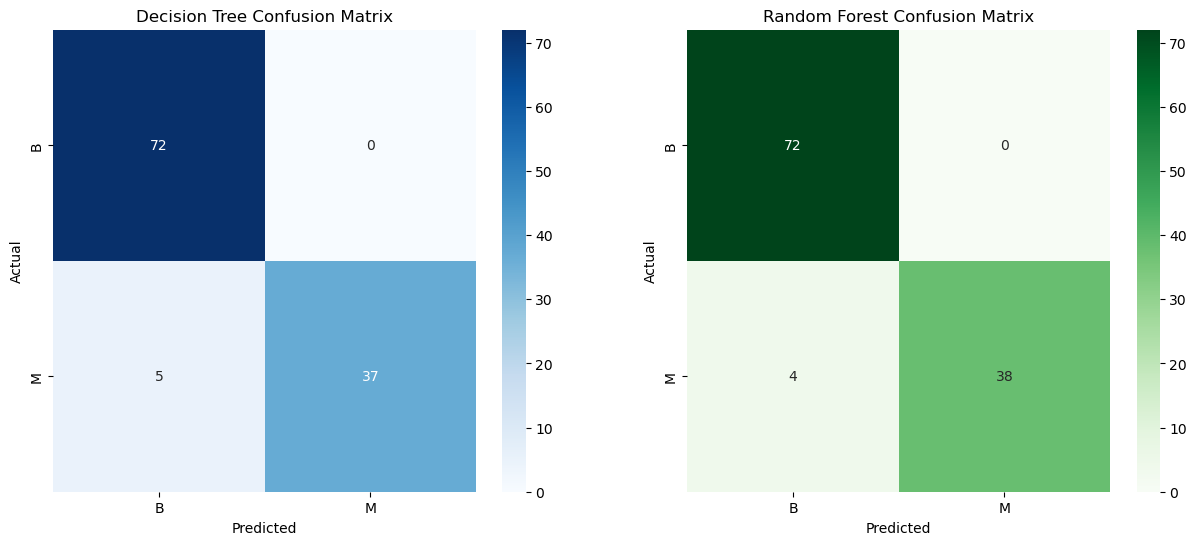

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=classes, yticklabels=classes)
ax1.set_title('Decision Tree Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax2, xticklabels=classes, yticklabels=classes)
ax2.set_title('Random Forest Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

save_plot('confusion_matrices')
plt.show()

### ROC Curve and AUC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved: roc_comparison


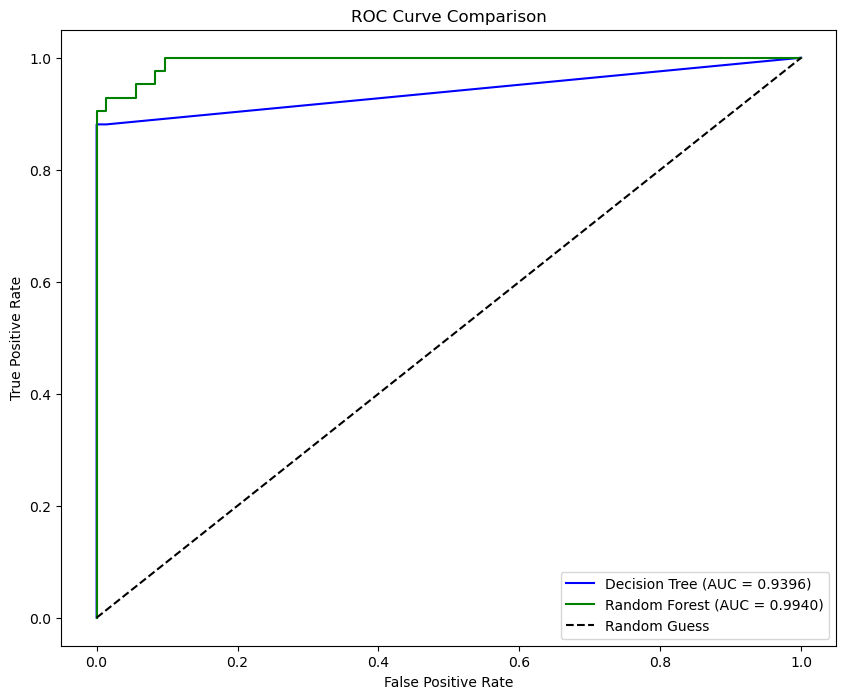

In [13]:
plt.figure(figsize=(10, 8))

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
save_plot('roc_comparison')
plt.show()

## 8. Observation Questions

- **How does tree depth affect overfitting in Decision Trees?**
  - Deep trees can capture noise in the training data, leading to perfect training accuracy but poor test performance (high variance). Constraining `max_depth` or increasing `min_samples_leaf` helps regularize the tree.

- **Which hyperparameter had the greatest impact on performance?**
  - For the Decision Tree, `max_depth` and `criterion` are often dominant. For Random Forest, `n_estimators` and `max_features` significantly influence the variance reduction.

- **How does Random Forest improve generalization?**
  - By averaging multiple trees trained on different bootstrap samples (Bagging) and random feature subsets, it cancels out individual tree errors and reduces the sensitivity to outliers, thus lowering variance.

- **Did ensemble learning always improve performance? Why or why not?**
  - In most complex datasets like WDBC, yes. However, if the base learners are highly correlated or the dataset is extremely small/simple, the overhead of an ensemble might not yield a massive gain, though it usually remains more robust.

## 9. Conclusion

Decision Tree and Random Forest models were implemented and evaluated using 5-fold cross-validation. Hyperparameters were selected based on average cross-validation performance, ensuring robust generalization. The results demonstrate that Random Forest reduces variance and improves stability compared to a single Decision Tree, achieving higher accuracy and a more robust AUC score on the Wisconsin Diagnostic Breast Cancer Dataset.